In [7]:
%matplotlib inline
import os
import sys

import gzip
import shutil
from struct import unpack
from collections import namedtuple, Counter, defaultdict
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
from datetime import timedelta
from time import time

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

## This NoteBook uses Stefan Jansen's Machine Learning for Trading code

Source:
1. [01_parse_itch_order_flow_messages](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/02_market_and_fundamental_data/01_NASDAQ_TotalView-ITCH_Order_Book/01_parse_itch_order_flow_messages.ipynb)
2. [02_rebuild_nasdaq_order_book](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/02_market_and_fundamental_data/01_NASDAQ_TotalView-ITCH_Order_Book/02_rebuild_nasdaq_order_book.ipynb)

In [8]:
test_data = pd.read_csv("../../../../Volumes/external_drive/nasdaq_itch/data/test_data.csv")
test_data.head()

,time,type,order_id,shares,price,direction
0,34200.00424,1,1,10,10,1
1,34200.00425,1,2,10,3,1
2,34200.00426,1,3,10,1,1
3,34200.00427,1,4,10,5,1
4,34200.00428,1,5,10,6,1


In [9]:
# set the data path to our external drive
data_path = Path("../../../../Volumes/external_drive/nasdaq_itch/data")
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'

In [10]:
URL = "https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/"
SOURCE_FILE = "12302019.NASDAQ_ITCH50.gz"

In [11]:
def may_be_download(url):
    """Download & unzip ITCH data if not yet available"""
    if not data_path.exists():
        print('Creating directory')
        data_path.mkdir()
    else: 
        print('Directory exists')

    filename = data_path / url.split('/')[-1]        
    if not filename.exists():
        print('Downloading...', url)
        urlretrieve(url, filename)
    else: 
        print('File exists')        

    unzipped = data_path / (filename.stem + '.bin')
    if not unzipped.exists():
        print('Unzipping to', unzipped)
        with gzip.open(str(filename), 'rb') as f_in:
            with open(unzipped, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    else: 
        print('File already unpacked')
    return unzipped

In [12]:
file_name = may_be_download(urljoin(URL, SOURCE_FILE))
date = file_name.name.split('.')[0]
file_name

Directory exists
File exists
File already unpacked


PosixPath('../../../../Volumes/external_drive/nasdaq_itch/data/12302019.NASDAQ_ITCH50.bin')

In [13]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>5.2f}'

In [14]:
message_data = pd.read_csv(data_path / "message_data.csv").sort_values('id').drop('id', axis=1)
message_data.head()

,Name,Offset,Length,Value,Notes
0,Message Type,0,1,S,System Event Message
1,Stock Locate,1,2,Integer,Always 0
2,Tracking Number,3,2,Integer,Nasdaq internal tracking number
3,Timestamp,5,6,Integer,Nanoseconds since midnight
4,Event Code,11,1,Alpha,See System Event Codes below


In [15]:
def clean_message_types(df):
    df.columns = [c.lower().strip() for c in df.columns]
    df.value = df.value.str.strip()
    df.name = (df.name
               .str.strip() # remove whitespace
               .str.lower()
               .str.replace(' ', '_')
               .str.replace('-', '_')
               .str.replace('/', '_'))
    df.notes = df.notes.str.strip()
    df['message_type'] = df.loc[df.name == 'message_type', 'value']
    return df
message_types = clean_message_types(message_data)
message_types.head()

,name,offset,length,value,notes,message_type
0,message_type,0,1,S,System Event Message,S
1,stock_locate,1,2,Integer,Always 0,NaN
2,tracking_number,3,2,Integer,Nasdaq internal tracking number,NaN
3,timestamp,5,6,Integer,Nanoseconds since midnight,NaN
4,event_code,11,1,Alpha,See System Event Codes below,NaN


In [16]:
message_labels = (message_types.loc[:, ['message_type', 'notes']]
                  .dropna()
                  .rename(columns={'notes': 'name'}))
message_labels.name = (message_labels.name
                       .str.lower()
                       .str.replace('message', '')
                       .str.replace('.', '')
                       .str.strip().str.replace(' ', '_'))
message_labels.to_csv(data_path / 'message_labels.csv', index=False)
message_labels.head()

<ipython-input-16-ddcf9094d4fe>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  message_labels.name = (message_labels.name


,message_type,name
0,S,system_event
5,R,stock_directory
23,H,stock_trading_action
31,Y,reg_sho_short_sale_price_test_restricted_indic...
37,L,market_participant_position


In [17]:
message_types.message_type = message_types.message_type.ffill()
message_types = message_types[message_types.name != 'message_type']
message_types.value = (message_types.value
                       .str.lower()
                       .str.replace(' ', '_')
                       .str.replace('(', '')
                       .str.replace(')', ''))
message_types.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 1 to 172
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          152 non-null    object
 1   offset        152 non-null    int64 
 2   length        152 non-null    int64 
 3   value         152 non-null    object
 4   notes         152 non-null    object
 5   message_type  152 non-null    object
dtypes: int64(2), object(4)
memory usage: 8.3+ KB


<ipython-input-17-84fd5d50a68f>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  message_types.value = (message_types.value
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [18]:
message_types.head()

,name,offset,length,value,notes,message_type
1,stock_locate,1,2,integer,Always 0,S
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S
3,timestamp,5,6,integer,Nanoseconds since midnight,S
4,event_code,11,1,alpha,See System Event Codes below,S
6,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R


In [19]:
message_types.to_csv(data_path / 'message_types.csv', index=False)

In [20]:
message_types = pd.read_csv(data_path / 'message_types.csv')
message_types.head()

,name,offset,length,value,notes,message_type
0,stock_locate,1,2,integer,Always 0,S
1,tracking_number,3,2,integer,Nasdaq internal tracking number,S
2,timestamp,5,6,integer,Nanoseconds since midnight,S
3,event_code,11,1,alpha,See System Event Codes below,S
4,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R


In [21]:
event_codes = {'O': 'Start of Messages',
               'S': 'Start of System Hours',
               'Q': 'Start of Market Hours',
               'M': 'End of Market Hours',
               'E': 'End of System Hours',
               'C': 'End of Messages'}

encoding = {'primary_market_maker': {'Y': 1, 'N': 0},
            'printable'           : {'Y': 1, 'N': 0},
            'buy_sell_indicator'  : {'B': 1, 'S': -1},
            'cross_type'          : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction' : {'B': 0, 'S': 1, 'N': 0, 'O': -1}}

formats = {
    ('integer', 2): 'H',  # int of length 2 => format string 'H'
    ('integer', 4): 'I',
    ('integer', 6): '6s',  # int of length 6 => parse as string, convert later
    ('integer', 8): 'Q',
    ('alpha',   1): 's',
    ('alpha',   2): '2s',
    ('alpha',   4): '4s',
    ('alpha',   8): '8s',
    ('price_4', 4): 'I',
    ('price_8', 8): 'Q',
}

In [22]:
message_types.loc[:, 'formats'] = (message_types[['value', 'length']].apply(tuple, axis=1).map(formats))
message_types.head()

,name,offset,length,value,notes,message_type,formats
0,stock_locate,1,2,integer,Always 0,S,H
1,tracking_number,3,2,integer,Nasdaq internal tracking number,S,H
2,timestamp,5,6,integer,Nanoseconds since midnight,S,6s
3,event_code,11,1,alpha,See System Event Codes below,S,s
4,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R,H


In [23]:
alpha_fields = message_types[message_types.value == 'alpha'].set_index('name')
alpha_msgs = alpha_fields.groupby('message_type')
alpha_formats = {k: v.to_dict() for k, v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k, v in alpha_msgs.length}

alpha_msgs.head()

,offset,length,value,notes,message_type,formats
name,,,,,,
event_code,11,1,alpha,See System Event Codes below,S,s
stock,11,8,alpha,Denotes the security symbol for the issue in t...,R,8s
market_category,19,1,alpha,Indicates Listing market or listing market tie...,R,s
financial_status_indicator,20,1,alpha,"For Nasdaq listed issues, this field indicates...",R,s
round_lots_only,25,1,alpha,Indicates if Nasdaq system limits order entry ...,R,s
issue_classification,26,1,alpha,Identifies the security class for the issue as...,R,s
stock,11,8,alpha,"Stock symbol, right padded with spaces",H,8s
trading_state,19,1,alpha,Indicates the current trading state for the st...,H,s
reserved,20,1,alpha,Reserved.,H,s


In [26]:
message_fields, fstring = {}, {}
for t, message in message_types.groupby('message_type'):
    message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())
    fstring[t] = '>' + ''.join(message.formats.tolist())

alpha_fields.info()
fstring

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, event_code to price_variation_indicator
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   offset        45 non-null     int64 
 1   length        45 non-null     int64 
 2   value         45 non-null     object
 3   notes         45 non-null     object
 4   message_type  45 non-null     object
 5   formats       45 non-null     object
dtypes: int64(2), object(4)
memory usage: 2.5+ KB


{'A': '>HH6sQsI8sI',
 'B': '>HH6sQ',
 'C': '>HH6sQIQsI',
 'D': '>HH6sQ',
 'E': '>HH6sQIQ',
 'F': '>HH6sQsI8sI4s',
 'H': '>HH6s8sss4s',
 'I': '>HH6sQQs8sIIIss',
 'J': '>HH6s8sIIII',
 'K': '>HH6s8sIsI',
 'L': '>HH6s4s8ssss',
 'P': '>HH6sQsI8sIQ',
 'Q': '>HH6sQ8sIQs',
 'R': '>HH6s8sssIss2ssssssIs',
 'S': '>HH6ss',
 'U': '>HH6sQQII',
 'V': '>HH6sQQQ',
 'W': '>HH6ss',
 'X': '>HH6sQI',
 'Y': '>HH6s8ss',
 'h': '>HH6s8sss'}

In [19]:
alpha_fields.head()

,offset,length,value,notes,message_type,formats
name,,,,,,
event_code,11,1,alpha,See System Event Codes below,S,s
stock,11,8,alpha,Denotes the security symbol for the issue in t...,R,8s
market_category,19,1,alpha,Indicates Listing market or listing market tie...,R,s
financial_status_indicator,20,1,alpha,"For Nasdaq listed issues, this field indicates...",R,s
round_lots_only,25,1,alpha,Indicates if Nasdaq system limits order entry ...,R,s


In [20]:
def format_alpha(mtype, data):
    """Process byte strings of type alpha"""

    for col in alpha_formats.get(mtype).keys():
        if mtype != 'R' and col == 'stock':
            data = data.drop(col, axis=1)
            continue
        data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
        if encoding.get(col):
            data.loc[:, col] = data.loc[:, col].map(encoding.get(col))
    return data

In [21]:
def store_messages(m):
    """Handle occasional storing of all messages"""
    with pd.HDFStore(itch_store) as store:
        for mtype, data in m.items():
            # convert to DataFrame
            data = pd.DataFrame(data)

            # parse timestamp info
            data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
            data.timestamp = pd.to_timedelta(data.timestamp)

            # apply alpha formatting
            if mtype in alpha_formats.keys():
                data = format_alpha(mtype, data)

            s = alpha_length.get(mtype)
            if s:
                s = {c: s.get(c) for c in data.columns}
            dc = ['stock_locate']
            if m == 'R':
                dc.append('stock')
            try:
                store.append(mtype,
                         data,
                         format='t',
                         min_itemsize=s,
                         data_columns=dc)
            except Exception as e:
                print(e)
                print(mtype)
                print(data.info())
                print(pd.Series(list(m.keys())).value_counts())
                data.to_csv(data_path / 'data.csv', index=False)
                return 1
    return 0

In [22]:
messages = defaultdict(list)
message_count = 0
message_type_counter = Counter()

In [23]:
start = time()
with file_name.open('rb') as data:
    while True:

        # determine message size in bytes
        message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)
        
        # get message type by reading first byte
        message_type = data.read(1).decode('ascii')        
        message_type_counter.update([message_type])

        # read & store message
        try:
            record = data.read(message_size - 1)
            message = message_fields[message_type]._make(unpack(fstring[message_type], record))
            messages[message_type].append(message)
        except Exception as e:
            print(e)
            print(message_type)
            print(record)
            print(fstring[message_type])
        
        # deal with system events
        if message_type == 'S':
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}')
            if message.event_code.decode('ascii') == 'C':
                store_messages(messages)
                break
        message_count += 1

        if message_count % 2.5e7 == 0:
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            d = format_time(time() - start)
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}\t{d}')
            res = store_messages(messages)
            if res == 1:
                print(pd.Series(dict(message_type_counter)).sort_values())
                break
            messages.clear()

print('Duration:', format_time(time() - start))

'S' object has no attribute 'stock'
S
b'\x00\x00\x00\x00\n\x11\xea\x0e\x8cCO'
>HH6ss

 Start of Messages
	03:04:32.06	           0
Duration: 00:00:00.84


In [24]:
counter = pd.Series(message_type_counter).to_frame('# Trades')
counter['Message Type'] = counter.index.map(message_labels.set_index('message_type').name.to_dict())
counter = counter[['Message Type', '# Trades']].sort_values('# Trades', ascending=False)
counter

<ipython-input-24-8bbc4676cf51>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  counter = pd.Series(message_type_counter).to_frame('# Trades')


,Message Type,# Trades


In [25]:
with pd.HDFStore(itch_store) as store:
    store.put('summary', counter)

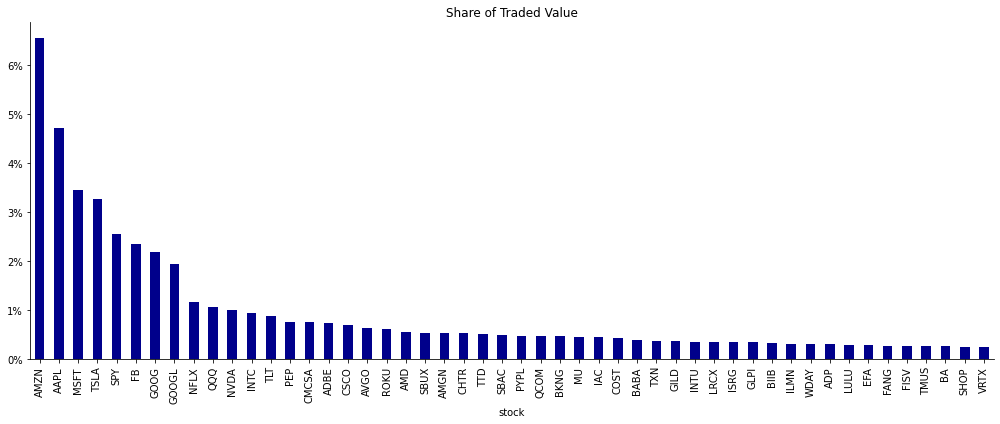

In [26]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())

trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='Share of Traded Value')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
plt.tight_layout()

In [9]:
stock = 'MSFT'
order_dict = {-1: 'sell', 1: 'buy'}

In [10]:
def get_messages(date, stock=stock):
    """Collect trading messages for given stock"""
    with pd.HDFStore(itch_store) as store:
        stock_locate = store.select('R', where='stock = stock').stock_locate.iloc[0]
        target = 'stock_locate = stock_locate'

        data = {}
        # trading message types
        messages = ['A', 'F', 'E', 'C', 'X', 'D', 'U', 'P', 'Q']
        for m in messages:
            data[m] = store.select(m, where=target).drop('stock_locate', axis=1).assign(type=m)

    order_cols = ['order_reference_number', 'buy_sell_indicator', 'shares', 'price']
    orders = pd.concat([data['A'], data['F']], sort=False, ignore_index=True).loc[:, order_cols]

    for m in messages[2: -3]:
        data[m] = data[m].merge(orders, how='left')

    data['U'] = data['U'].merge(orders, how='left',
                                right_on='order_reference_number',
                                left_on='original_order_reference_number',
                                suffixes=['', '_replaced'])

    data['Q'].rename(columns={'cross_price': 'price'}, inplace=True)
    data['X']['shares'] = data['X']['cancelled_shares']
    data['X'] = data['X'].dropna(subset=['price'])

    data = pd.concat([data[m] for m in messages], ignore_index=True, sort=False)
    data['date'] = pd.to_datetime(date, format='%m%d%Y')
    data.timestamp = data['date'].add(data.timestamp)
    data = data[data.printable != 0]

    # drop_cols = ['tracking_number', 'order_reference_number', 'original_order_reference_number',
    #              'cross_type', 'new_order_reference_number', 'attribution', 'match_number',
    #              'printable', 'date', 'cancelled_shares']
    #return data.drop(drop_cols, axis=1).sort_values('timestamp').reset_index(drop=True)
    return data.sort_values('timestamp').reset_index(drop=True)

In [11]:
messages = get_messages(date=date)
messages.info(null_counts=True)

<ipython-input-11-0239a52c211b>:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  messages.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519325 entries, 0 to 1519324
Data columns (total 19 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   tracking_number                  1519325 non-null  int64         
 1   timestamp                        1519325 non-null  datetime64[ns]
 2   order_reference_number           1428038 non-null  float64       
 3   buy_sell_indicator               1421905 non-null  float64       
 4   shares                           1513192 non-null  float64       
 5   price                            1513192 non-null  float64       
 6   type                             1519325 non-null  object        
 7   attribution                      2772 non-null     object        
 8   executed_shares                  60509 non-null    float64       
 9   match_number                     67689 non-null    float64       
 10  printable                     

In [12]:
with pd.HDFStore(order_book_store) as store:
    key = f'{stock}/messages'
    store.put(key, messages)
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../../../../Volumes/external_drive/nasdaq_itch/data/order_book.h5
/AAPL/messages            frame        (shape->[1519325,19])
/MSFT/messages            frame        (shape->[1220846,19])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['type', 'attribution'], dtype='object')]

  if (await self.run_code(code, result,  async_=asy)):


In [13]:
messages

,tracking_number,timestamp,order_reference_number,buy_sell_indicator,shares,price,type,attribution,executed_shares,match_number,printable,execution_price,cancelled_shares,original_order_reference_number,new_order_reference_number,shares_replaced,price_replaced,cross_type,date
0,0,2019-12-30 04:00:00.007075802,11825.0,-1.0,16.0,2999000.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30
1,0,2019-12-30 04:00:02.105991319,74473.0,1.0,73.0,2890000.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30
2,0,2019-12-30 04:00:09.160475329,104861.0,1.0,100.0,2498200.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30
3,0,2019-12-30 04:00:10.482288232,105925.0,1.0,80.0,2637000.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30
4,0,2019-12-30 04:00:19.220189075,110017.0,1.0,30.0,2890100.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519320,0,2019-12-30 20:00:00.096435337,249705545.0,-1.0,1000.0,3750000.0,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30
1519321,0,2019-12-30 20:00:00.096526406,249705061.0,-1.0,1783.0,3500500.0,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30
1519322,0,2019-12-30 20:00:00.096671269,249705125.0,-1.0,908.0,3000000.0,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30
1519323,0,2019-12-30 20:00:00.096732858,250244313.0,1.0,307.0,2912600.0,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30
